# Load modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 252 GB / available: 209 GB / percent used: 16.9 %


# Load model data

In [2]:
# Define period
period = slice('1981','2014')

# Define zone
latlim=(10,50)
lonlim=(60,110)

# Model
institute = 'IPSL'
model = 'IPSL-CM6A-LR'

# Check the differences between ERA-Interim and model for Near-Surface Air Temperature

## Load first member

In [3]:
realization = 'r1i1p1f1'
var = 'tas'
table = 'Amon'

# Load historical
tas = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', 
    combine='by_coords'
).sel(time=period)[var]-273.15

# ERA-Interim
tas_era = xr.open_mfdataset(
    '/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_SF/*/t2.*.asmei.GLOBAL_075.nc',
    combine='by_coords', parallel=True
).t2.sel(time=period).load()-273.15

In [4]:
# HR
tas_HR = xr.open_mfdataset(
    '/bdd/CMIP6/HighResMIP/'+institute+'/IPSL-CM6A-ATM-HR/highresSST-present/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]-273.15

## Regrid

In [5]:
regridder_HR = xe.Regridder(tas_HR, tas, 'bilinear', periodic=True, reuse_weights=True)
tas_HR_regrid = regridder_HR(tas_HR)

Reuse existing file: bilinear_361x512_143x144_peri.nc


In [6]:
regridder = xe.Regridder(tas_era, tas, 'bilinear', periodic=True, reuse_weights=True)
tas_era_regrid = regridder(tas_era)

Reuse existing file: bilinear_241x480_143x144_peri.nc


## Compute clim

In [12]:
tas_HR_clim = tas_HR.mean('time')
tas_HR_regrid_clim = tas_HR_regrid.mean('time')
tas_era_regrid_clim = tas_era_regrid.mean('time')

In [13]:
tas_bias = tas_HR_regrid_clim-tas_era_regrid_clim

In [8]:
lonlim

(60, 110)

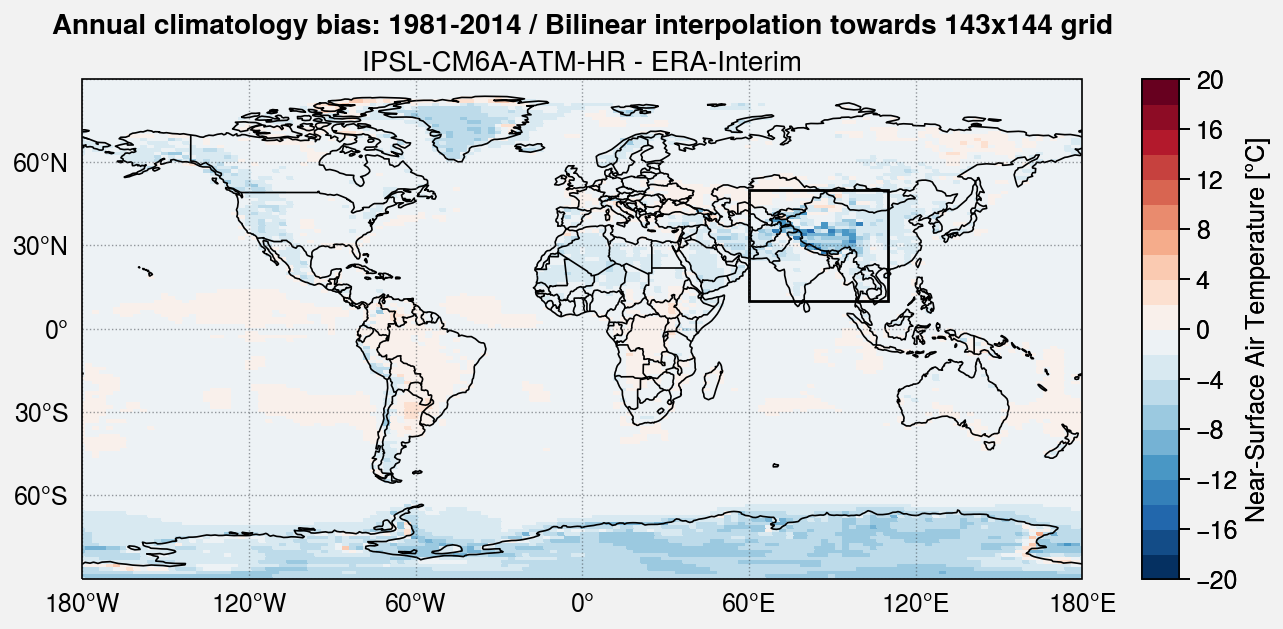

In [15]:
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

dx=2.5
dy=1.2676

f, axs = plot.subplots(proj='cyl', ncols=1, nrows=1, axwidth=5)

m = axs[0].pcolormesh(tas_bias, cmap='RdBu_r', levels=plot.arange(-20,20,2))
axs[0].format(title='IPSL-CM6A-ATM-HR - ERA-Interim')

f.colorbar(m, label='Near-Surface Air Temperature [°C]')


# Add box   
axs[0].add_patch(mpatches.Rectangle(
    xy=[lonlim[0], latlim[0]], width=lonlim[1]-lonlim[0], height=latlim[1]-latlim[0],
    transform=ccrs.PlateCarree(), fill=False
))


axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Annual climatology bias: 1981-2014 / Bilinear interpolation towards 143x144 grid",
    lonlines=60, latlines=30, abc=False
)

var = 'ta'
# f.save('img/'+var+'/tas_IPSL_CMIP6_HR-ERAI_bias_global.png')
# f.save('img/'+var+'/tas_IPSL_CMIP6_HR-ERAI_bias_global.pdf')

# Load surface pressure for masking ERA-Interim
http://clipc-services.ceda.ac.uk/dreq/u/8c9504d28596e05586c8e193082ac617.html

In [16]:
realization = 'r1i1p1f1'
var = 'ps'
table = 'Amon'

# Load HR
ps = xr.open_mfdataset(
    '/bdd/CMIP6/HighResMIP/'+institute+'/IPSL-CM6A-ATM-HR/highresSST-present/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

# ERA-Interim
ps_era = xr.open_mfdataset(
    "/data/mlalande/ERAI/sp/sp_ERAI_*.nc",
    combine='by_coords', parallel=True
).sp.sel(time=period).load()

In [17]:
ps_era_regrid = regridder(ps_era)

# Get the minimum pressure (finally not used)
ps_min = ps.min('time')
ps_era_regrid_min = ps_era_regrid.min('time')

# Load Air Temperature

In [18]:
var ='ta'

ta = xr.open_mfdataset(
    '/bdd/CMIP6/HighResMIP/'+institute+'/IPSL-CM6A-ATM-HR/highresSST-present/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]-273.15

ta_era = xr.open_mfdataset(
    '/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_PL/*/ta.*.apmei.GLOBAL_075.nc',
    combine='by_coords', parallel=True
).ta.sel(time=period)-273.15

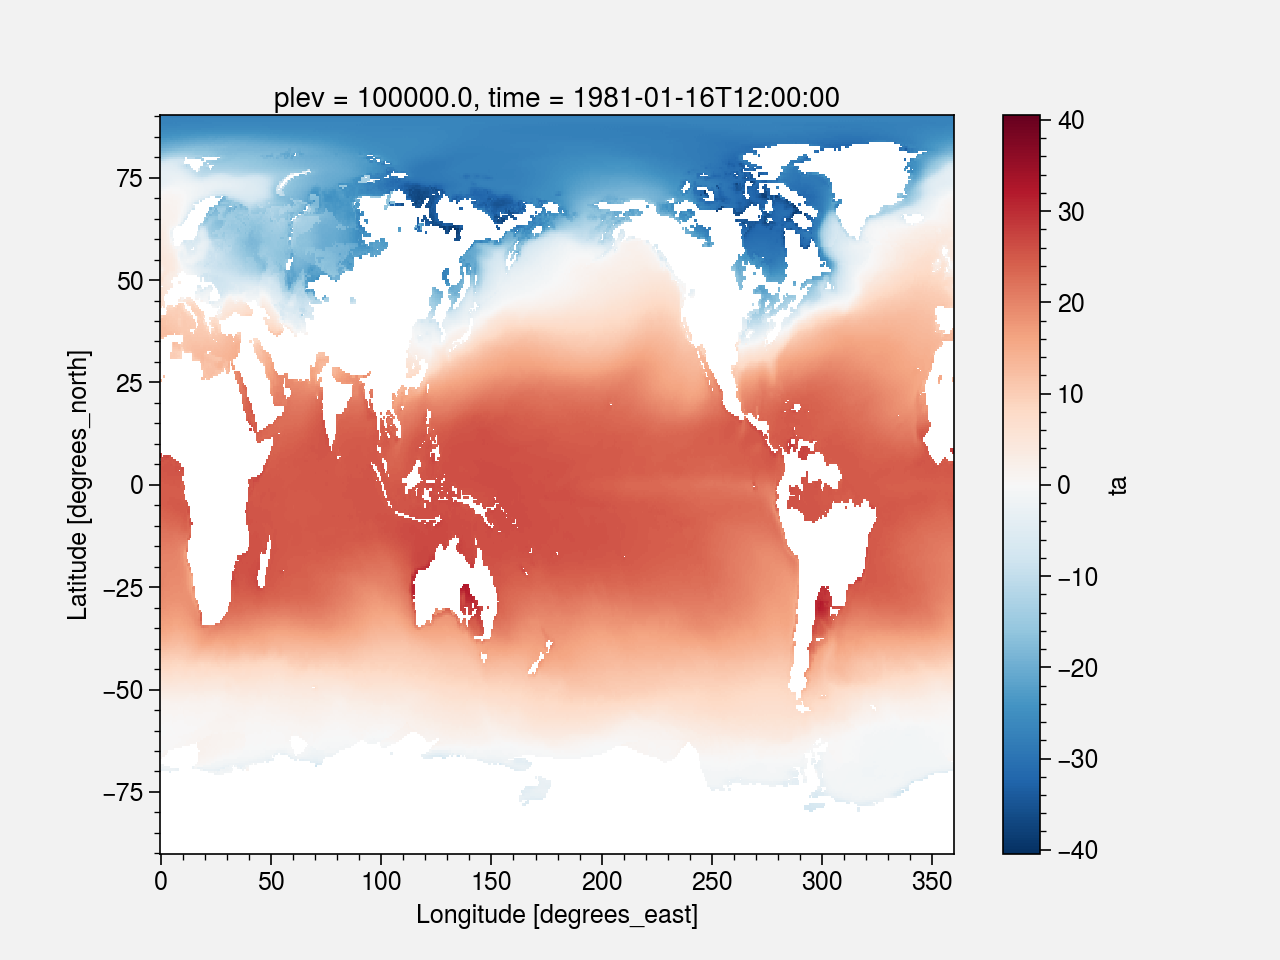

In [34]:
ta[0][0].plot()

## Regrid horizontal

In [19]:
# Regrid horizontal
ta_era_regrid = regridder(ta_era)

In [20]:
# Regrid horizontal
ta_regrid = regridder_HR(ta)

## Mask vertical values > ps

In [21]:
ta_era_regrid_masked = ta_era_regrid.where(ta_era_regrid.level <= ps_era_regrid/100)

## Regrid vertical

In [25]:
ta_era_regrid_masked_v = ta_era_regrid_masked.interp(level=(ta.plev.values/100), method='linear')

## Compute climatologie

In [26]:
# ta_clim = ta.mean('time', skipna=False).load()
ta_regrid_clim = ta_regrid.mean('time', skipna=False).load()
ta_era_regrid_masked_clim = ta_era_regrid_masked.mean('time', skipna=False).load()
ta_era_regrid_masked_v_clim = ta_era_regrid_masked_v.mean('time', skipna=False).load()

ta_bias = ta_regrid_clim-ta_era_regrid_masked_v_clim.values

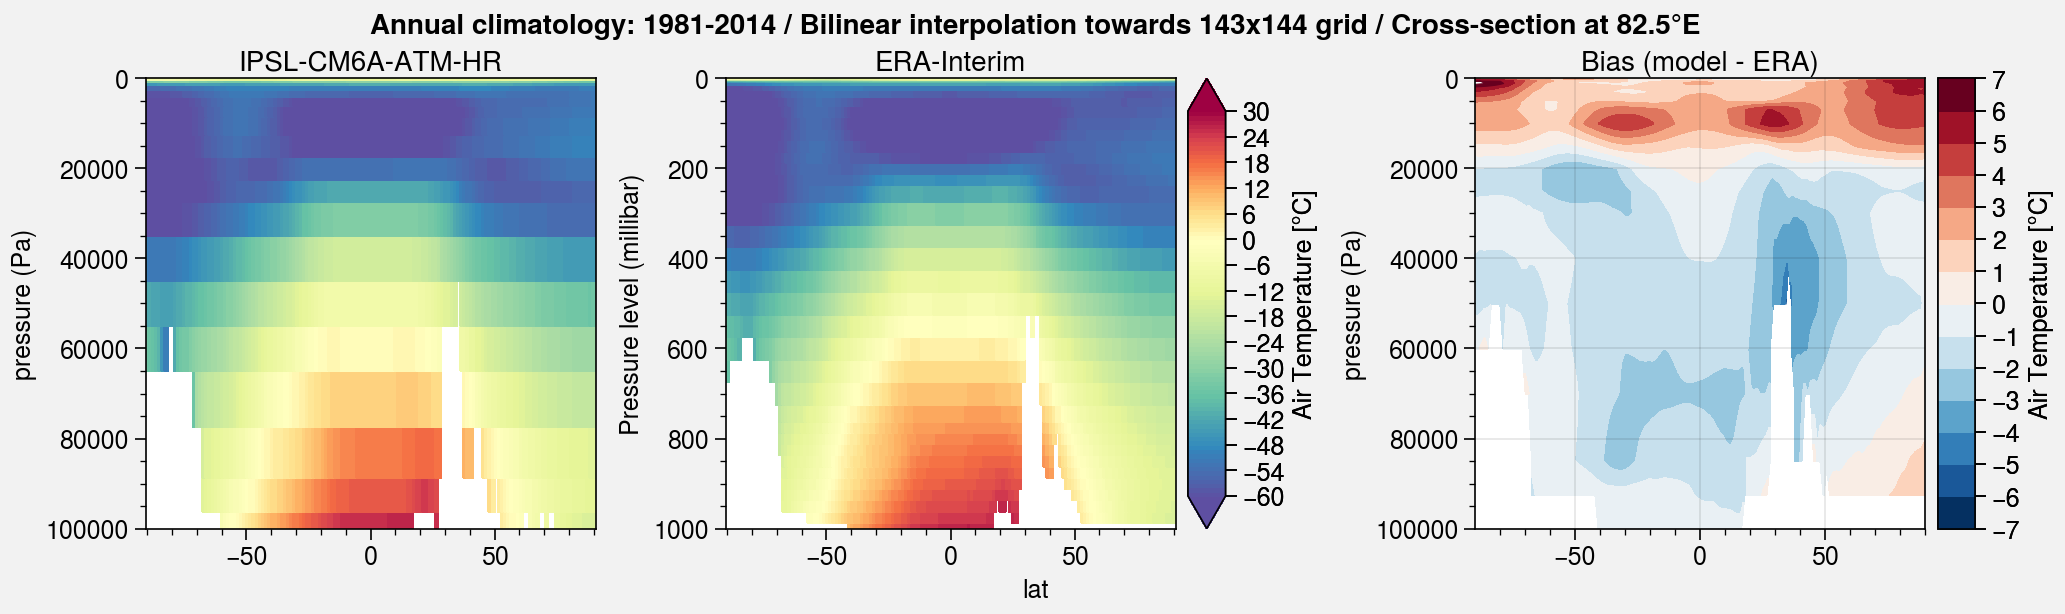

In [29]:
#Check colorbars 
levels = plot.arange(-60,30,1)
extend='both'
cmap='Spectral'

f, axs = plot.subplots(nrows=1, ncols=3, sharey=0)

# Model
m1 = axs[0].pcolormesh(ta_regrid_clim.sel(lon=82.5), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[0].format(ylim=(100000,0), title='IPSL-CM6A-ATM-HR')

# ERA-Interim
axs[1].pcolormesh(ta_era_regrid_masked_clim.sel(lon=82.5), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[1].format(ylim=(1000,0), title='ERA-Interim')
axs[1].colorbar(m1, label='Air Temperature [°C]')

# Bias
m2 = axs[2].contourf(ta_bias.sel(lon=82.5), cmap='BuRd', levels=plot.arange(-7,7,1))
axs[2].format(ylim=(100000,0), title='Bias (model - ERA)')
axs[2].colorbar(m2, label='Air Temperature [°C]')


axs.format(
    suptitle="Annual climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid / Cross-section at 82.5°E"
)

# f.save('img/ta/slice_lon_82_5_ta_pcolormesh_global_HR.png')
# f.save('img/ta/slice_lon_82_5_ta_pcolormesh_global_HR.pdf')

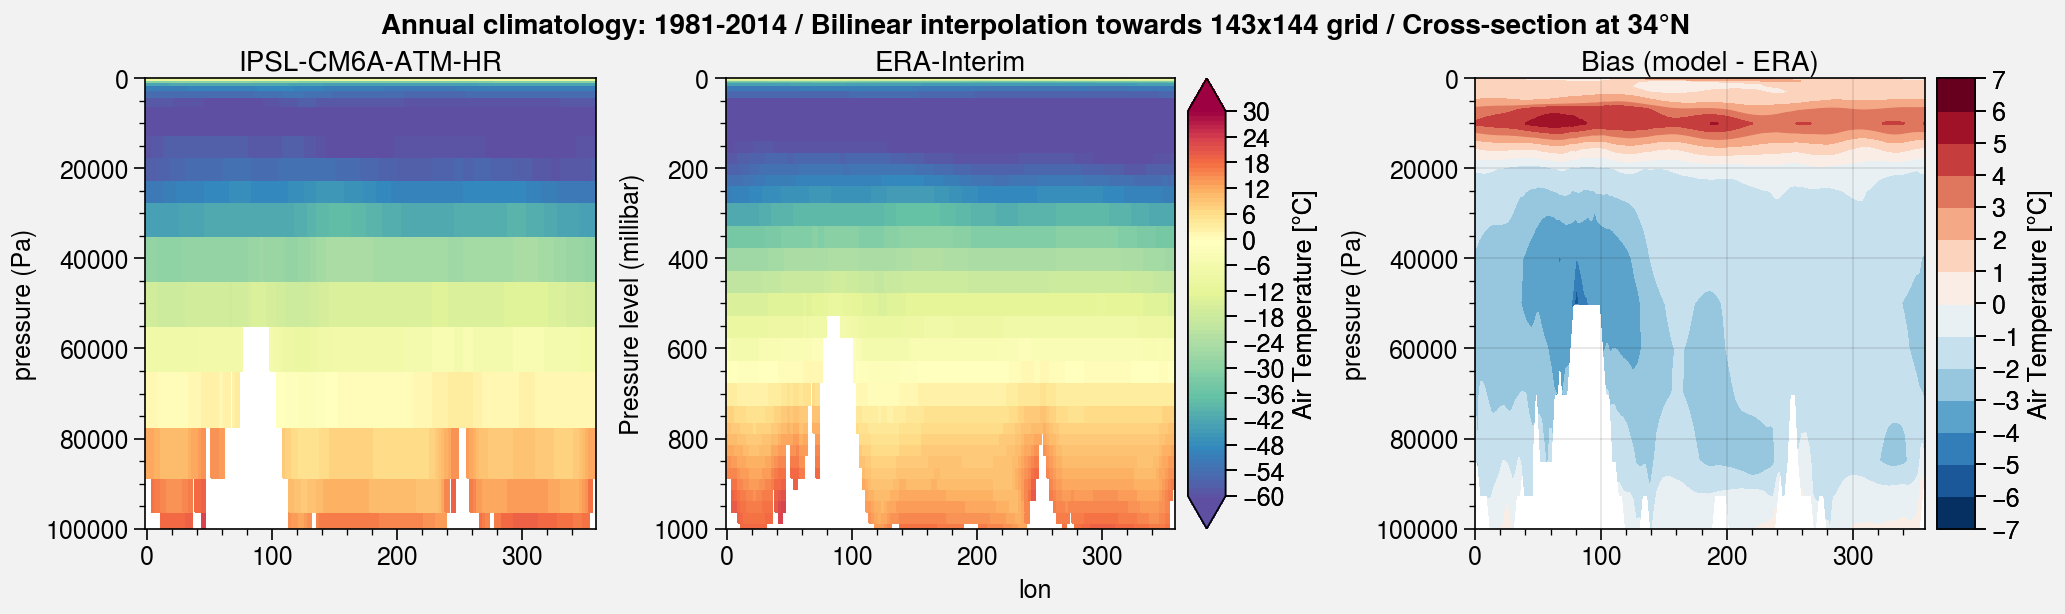

In [31]:
#Check colorbars 
levels = plot.arange(-60,30,1)
extend='both'
cmap='Spectral'

f, axs = plot.subplots(nrows=1, ncols=3, sharey=0)

# Model
m1 = axs[0].pcolormesh(ta_regrid_clim.sel(lat=34.225353), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[0].format(ylim=(100000,0), title='IPSL-CM6A-ATM-HR')

# ERA-Interim
axs[1].pcolormesh(ta_era_regrid_masked_clim.sel(lat=34.225353), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[1].format(ylim=(1000,0), title='ERA-Interim')
axs[1].colorbar(m1, label='Air Temperature [°C]')

# Bias
m2 = axs[2].contourf(ta_bias.sel(lat=34.225353), cmap='BuRd', levels=plot.arange(-7,7,1))
axs[2].format(ylim=(100000,0), title='Bias (model - ERA)')
axs[2].colorbar(m2, label='Air Temperature [°C]')


axs.format(
    suptitle="Annual climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid / Cross-section at 34°N"
)

# f.save('img/ta/slice_lat_34_ta_pcolormesh_global_HR.png')
# f.save('img/ta/slice_lat_34_ta_pcolormesh_global_HR.pdf')

# Zonal and meridional mean global / HM / global-HM

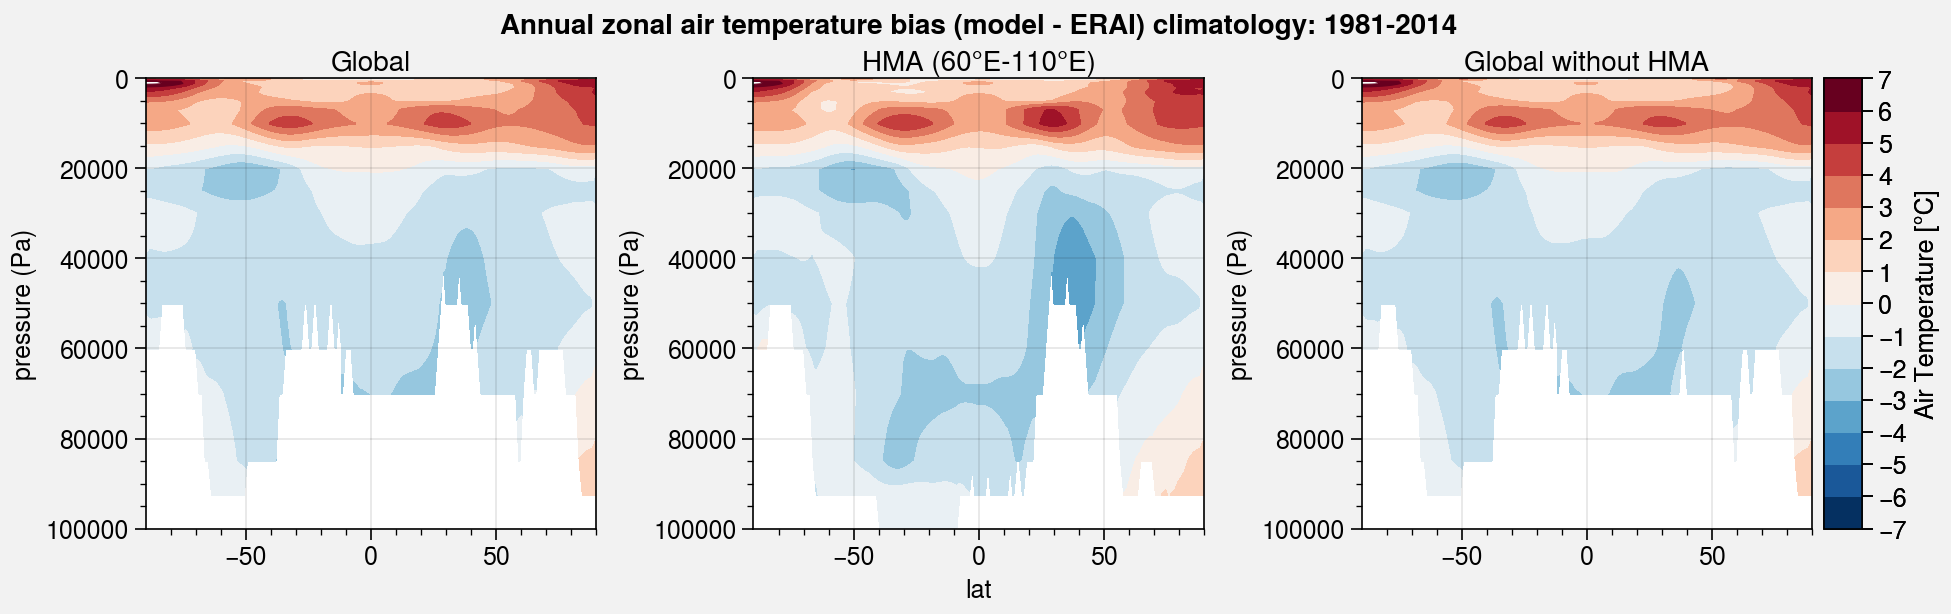

In [32]:
#Check colorbars 
levels=plot.arange(-7,7,1)
extend='both'
cmap='BuRd'

f, axs = plot.subplots(nrows=1, ncols=3, sharey=0)

# Model
axs[0].contourf(ta_bias.mean('lon', skipna=False), cmap=cmap, levels=levels)
axs[0].format(ylim=(100000,0), title='Global')

# ERA-Interim
axs[1].contourf(ta_bias.sel(lon=slice(lonlim[0],lonlim[1])).mean('lon', skipna=False), cmap=cmap, levels=levels)
axs[1].format(ylim=(100000,0), title='HMA (60°E-110°E)')

# Bias
m2 = axs[2].contourf(ta_bias.where((ta_bias.lon < 60) | (ta_bias.lon > 110), drop=True).mean('lon', skipna=False), cmap=cmap, levels=levels)
axs[2].format(ylim=(100000,0), title='Global without HMA')
axs[2].colorbar(m2, label='Air Temperature [°C]')


axs.format(
    suptitle="Annual zonal air temperature bias (model - ERAI) climatology: 1981-2014"
)

# f.save('img/ta/zonal_ta_global_HMA.png')
# f.save('img/ta/zonal_ta_global_HMA.pdf')